In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [2]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=100, verbose=1)

# 1. Create Data for Toy Problem

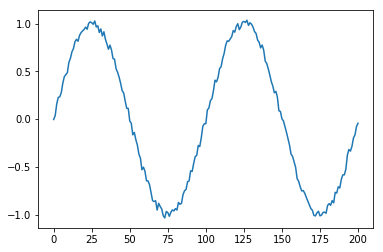

In [3]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 100
f = toy_problem(T)
plt.plot(f)

# 2a. Prepare Input Data to Train the Model

In [4]:
length_of_sequences = 2*T
maxlen = 25
data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# 2b. Split Data into Training and Valdiation Set 

In [5]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y, test_size=N_validation)

# 3. Prepare Model Functions for Graph

In [6]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.Variable(initial, name=name)
    
def bias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [11]:

def infere_mn(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    U = weight_variable([n_in, n_hidden], 'U') # going to combine this as (x, U)
    W = weight_variable([n_hidden, n_hidden], 'W')
    b = bias_variable([n_hidden], 'b')
    c = bias_variable([n_out], 'c')
    
    
    with tf.variable_scope('RNN'):
        hlist = []
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
            h_i = tf.tanh(tf.matmul(x[:, i, :], U) + tf.matmul(h_prev, W) + b)
            hlist.append(h_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

# 4. Define Graph

In [16]:
tf.reset_default_graph()

maxlen = 25
n_hidden = 20
n_out = 1
n_in = 1

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
y = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, 
              n_in=n_in)
loss = loss(y, t)
train_step = training(loss)


# 5. Run Computational Graph

In [17]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss:  0.427959
epoch: 1  validation loss:  0.391069
epoch: 2  validation loss:  0.186972
epoch: 3  validation loss:  0.113991
epoch: 4  validation loss:  0.0782149
epoch: 5  validation loss:  0.0620373
epoch: 6  validation loss:  0.0475042
epoch: 7  validation loss:  0.0408997
epoch: 8  validation loss:  0.0353741
epoch: 9  validation loss:  0.0317298
epoch: 10  validation loss:  0.0277844
epoch: 11  validation loss:  0.0251293
epoch: 12  validation loss:  0.0230311
epoch: 13  validation loss:  0.0215002
epoch: 14  validation loss:  0.0200781
epoch: 15  validation loss:  0.0186811
epoch: 16  validation loss:  0.0184604
epoch: 17  validation loss:  0.0166342
epoch: 18  validation loss:  0.0154343
epoch: 19  validation loss:  0.0153187
epoch: 20  validation loss:  0.0144156
epoch: 21  validation loss:  0.013564
epoch: 22  validation loss:  0.0130436
epoch: 23  validation loss:  0.0125763
epoch: 24  validation loss:  0.0118825
epoch: 25  validation loss:  0.0115273
e

epoch: 209  validation loss:  0.00214709
epoch: 210  validation loss:  0.00223456
epoch: 211  validation loss:  0.0022553
epoch: 212  validation loss:  0.00241066
epoch: 213  validation loss:  0.00229292
epoch: 214  validation loss:  0.00211158
epoch: 215  validation loss:  0.00212811
epoch: 216  validation loss:  0.00221218
epoch: 217  validation loss:  0.00247105
epoch: 218  validation loss:  0.00210218
epoch: 219  validation loss:  0.00218839
epoch: 220  validation loss:  0.00207219
epoch: 221  validation loss:  0.00219622
epoch: 222  validation loss:  0.00205
epoch: 223  validation loss:  0.00221838
epoch: 224  validation loss:  0.00209304
epoch: 225  validation loss:  0.00208731
epoch: 226  validation loss:  0.00232153
epoch: 227  validation loss:  0.0023342
epoch: 228  validation loss:  0.00202589
epoch: 229  validation loss:  0.00224339
epoch: 230  validation loss:  0.0021625
epoch: 231  validation loss:  0.00210879
epoch: 232  validation loss:  0.00225676
epoch: 233  validation

epoch: 418  validation loss:  0.00159171
epoch: 419  validation loss:  0.0016274
epoch: 420  validation loss:  0.00159859
epoch: 421  validation loss:  0.00161912
epoch: 422  validation loss:  0.00168164
epoch: 423  validation loss:  0.00186089
epoch: 424  validation loss:  0.00166254
epoch: 425  validation loss:  0.00160627
epoch: 426  validation loss:  0.00157607
epoch: 427  validation loss:  0.00165319
epoch: 428  validation loss:  0.0016546
epoch: 429  validation loss:  0.00188354
epoch: 430  validation loss:  0.00170313
epoch: 431  validation loss:  0.00157564
epoch: 432  validation loss:  0.00160128
epoch: 433  validation loss:  0.00177833
epoch: 434  validation loss:  0.0016775
epoch: 435  validation loss:  0.00156529
epoch: 436  validation loss:  0.00165506
epoch: 437  validation loss:  0.00164601
epoch: 438  validation loss:  0.00165539
epoch: 439  validation loss:  0.00158463
epoch: 440  validation loss:  0.00180145
epoch: 441  validation loss:  0.00175291
epoch: 442  validat

# 6. Show Results

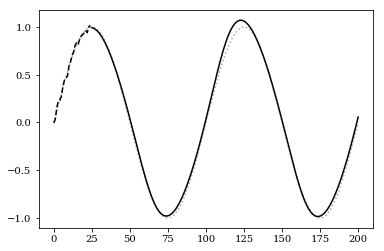

In [18]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# 7. Inspect Variables

In [ ]:
#tf.reset_default_graph()
collections=[tf.GraphKeys.GLOBAL_VARIABLES]
tf.get_collection(collections[0])

# 3. Define Functions for Model

In [ ]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    return y, cell.variables




# 4. Define TF Graph

#### What happened to the variables in RNN cell?

In [ ]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)